In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!nvidia-smi

Fri Apr 12 06:26:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:

import os
import glob
import random
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda')

In [9]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Count of using GPUs: 1


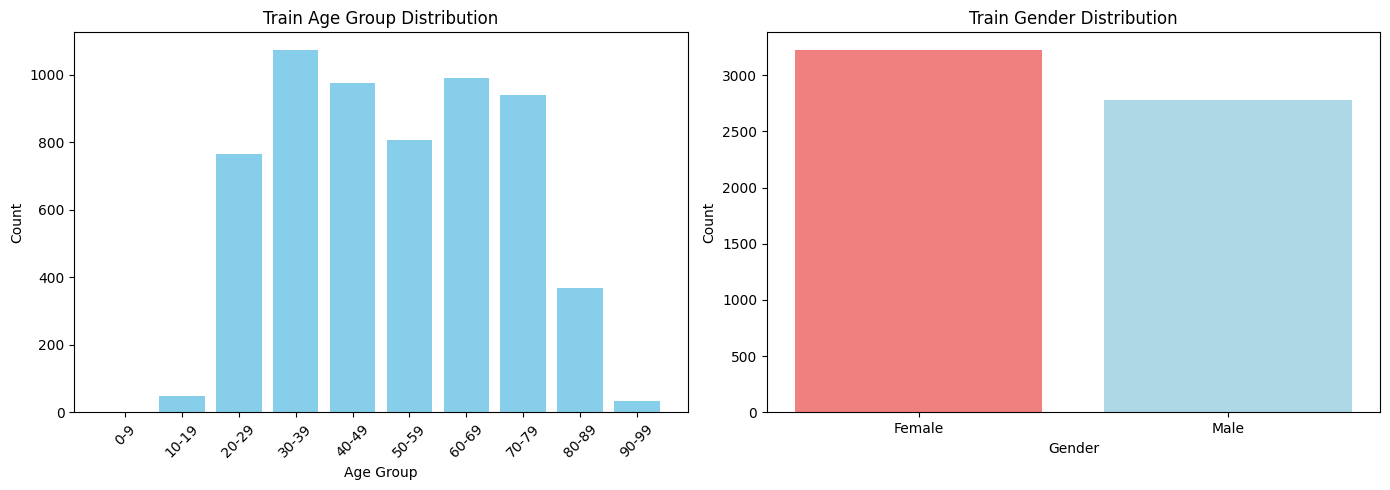

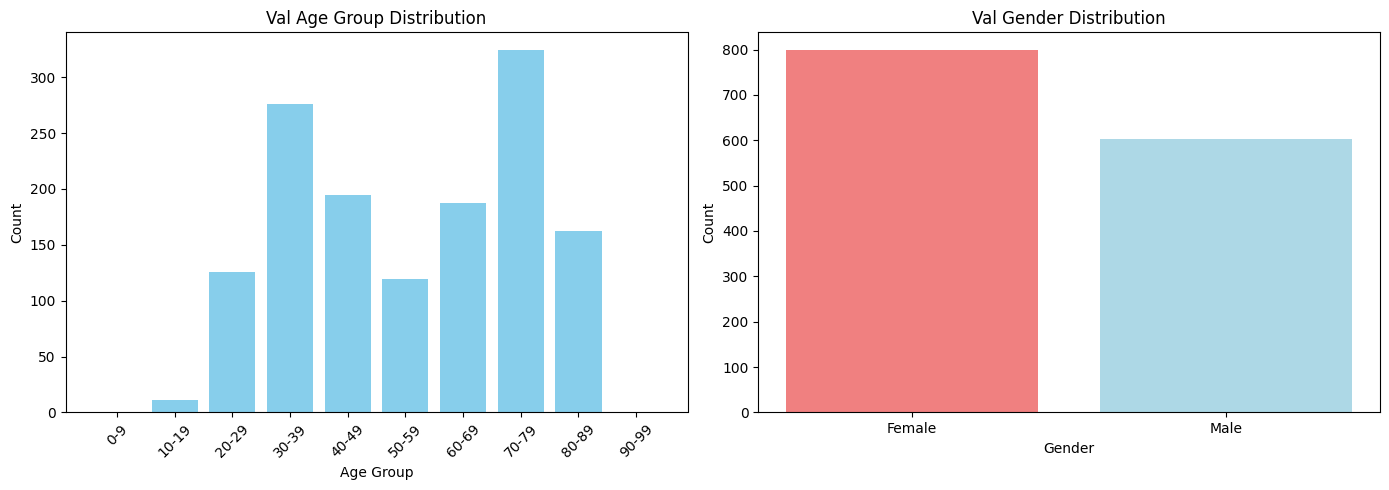

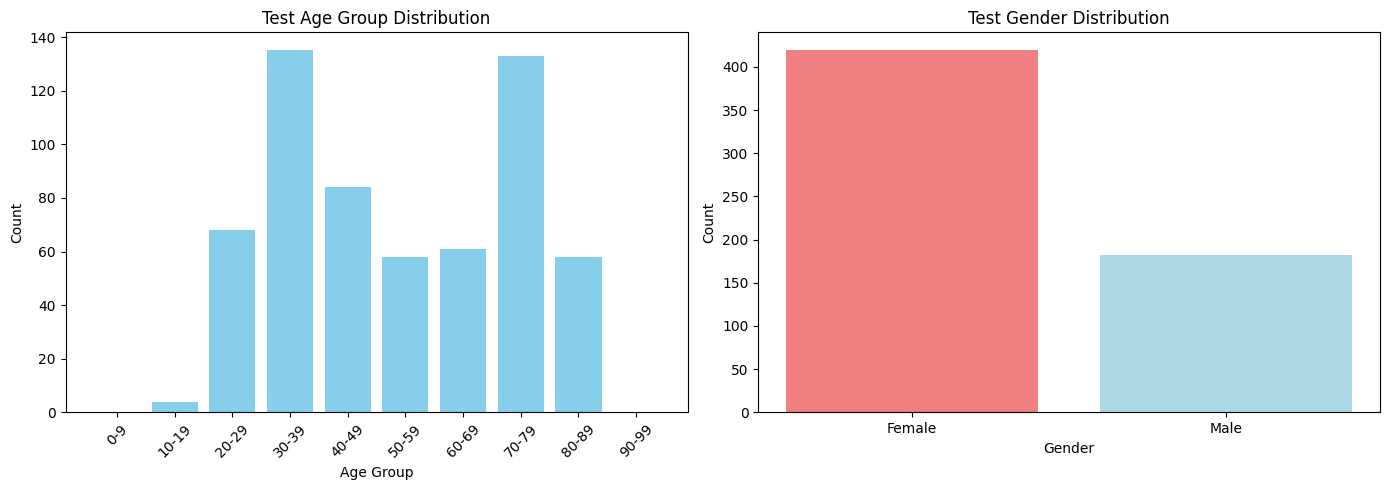

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def load_and_visualize_data(root_dir):
    splits = ['train', 'val', 'test']
    age_bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
    age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

    for split in splits:
        age_csv = pd.read_csv(os.path.join(root_dir, f'{split}_age.csv'), header=None, names=['index', 'age'])
        gender_csv = pd.read_csv(os.path.join(root_dir, f'{split}_gender.csv'), header=None, names=['index', 'gender'])
        data = pd.merge(age_csv, gender_csv, on='index')

        data['age'] = pd.to_numeric(data['age'], errors='coerce')
        data.dropna(subset=['age'], inplace=True)

        data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        age_group_counts = data['age_group'].value_counts().reindex(age_labels)  
        axes[0].bar(age_group_counts.index, age_group_counts.values, color='skyblue')
        axes[0].set_title(f'{split.capitalize()} Age Group Distribution')
        axes[0].set_xlabel('Age Group')
        axes[0].set_ylabel('Count')
        axes[0].tick_params(axis='x', rotation=45) 

        gender_counts = data['gender'].value_counts().sort_index()
        axes[1].bar(['Female', 'Male'], gender_counts.values, color=['lightcoral', 'lightblue'])
        axes[1].set_title(f'{split.capitalize()} Gender Distribution')
        axes[1].set_xlabel('Gender')
        axes[1].set_ylabel('Count')

        plt.tight_layout()
        plt.show()


root_dir = '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/4'
load_and_visualize_data(root_dir)

In [ ]:
def display_sample_images(root_dir, split, num_samples=1):
    age_csv_path = os.path.join(root_dir, f'{split}_age.csv')
    gender_csv_path = os.path.join(root_dir, f'{split}_gender.csv')
    age_df = pd.read_csv(age_csv_path, header=None, names=['index', 'age'])
    gender_df = pd.read_csv(gender_csv_path, header=None, names=['index', 'gender'])
    data = pd.merge(age_df, gender_df, on='index')
    sampled_df = data.sample(n=num_samples)
    img_dir = os.path.join(root_dir, split)

    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 5, 5))
    if num_samples == 1:
        axs = [axs]  

    for idx, (index, row) in enumerate(sampled_df.iterrows()):
        img_path = os.path.join(img_dir, f"{str(row['index']).zfill(6)}.png")
        if not os.path.exists(img_path):
            print(f"File does not exist: {img_path}")
            continue
        image = Image.open(img_path).convert('RGB')
        axs[idx].imshow(image)
        gender_label = 'Male' if int(row['gender']) == 1 else 'Female'
        axs[idx].set_title(f"Age: {row['age']}, Gender: {gender_label}")
        axs[idx].axis('off')

    plt.tight_layout()
    plt.show()

Train Sample Images:


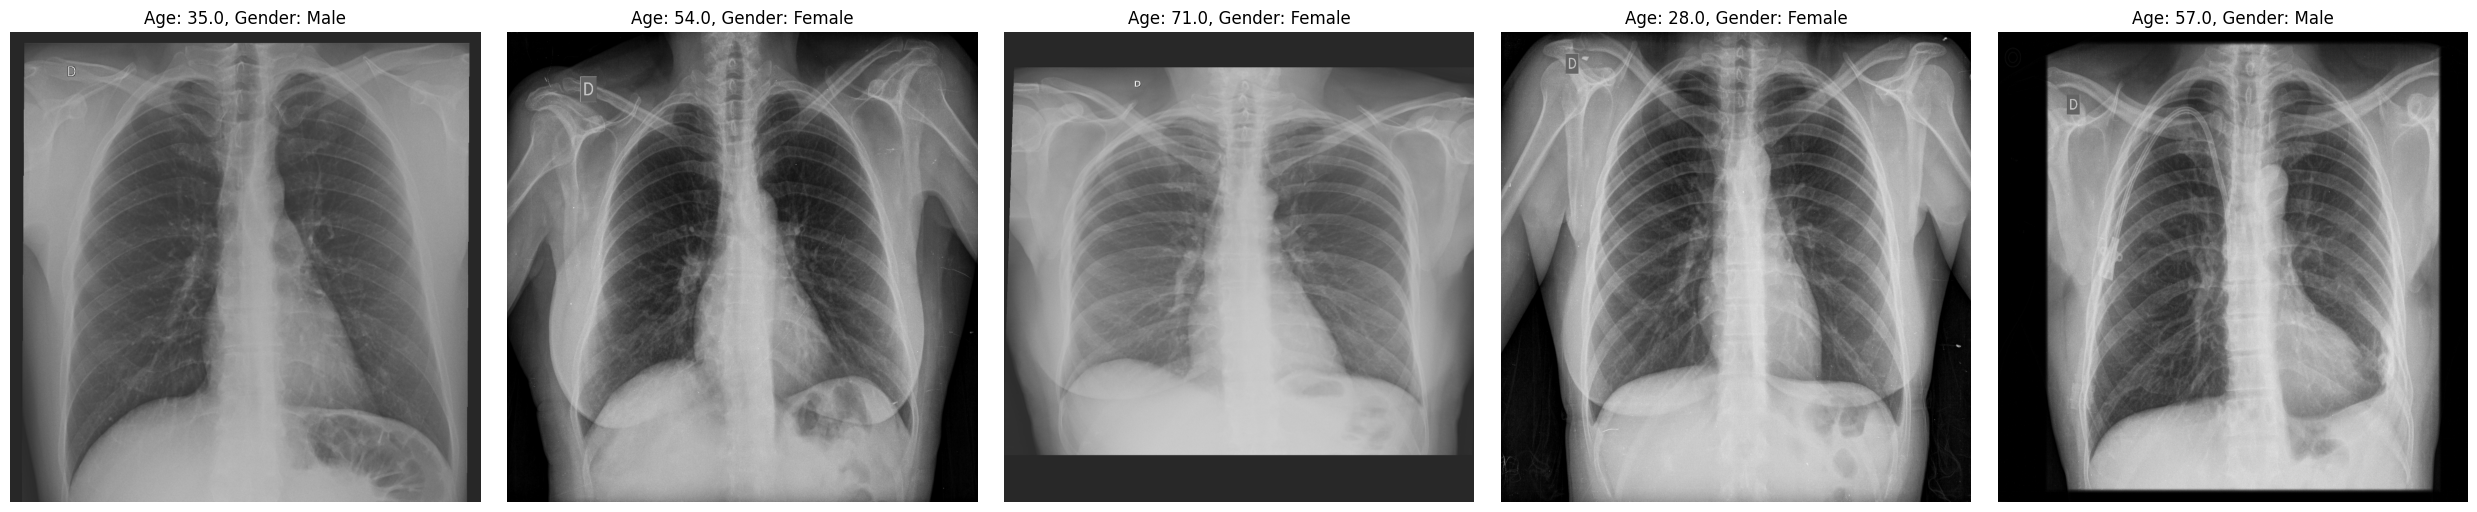

Val Sample Images:


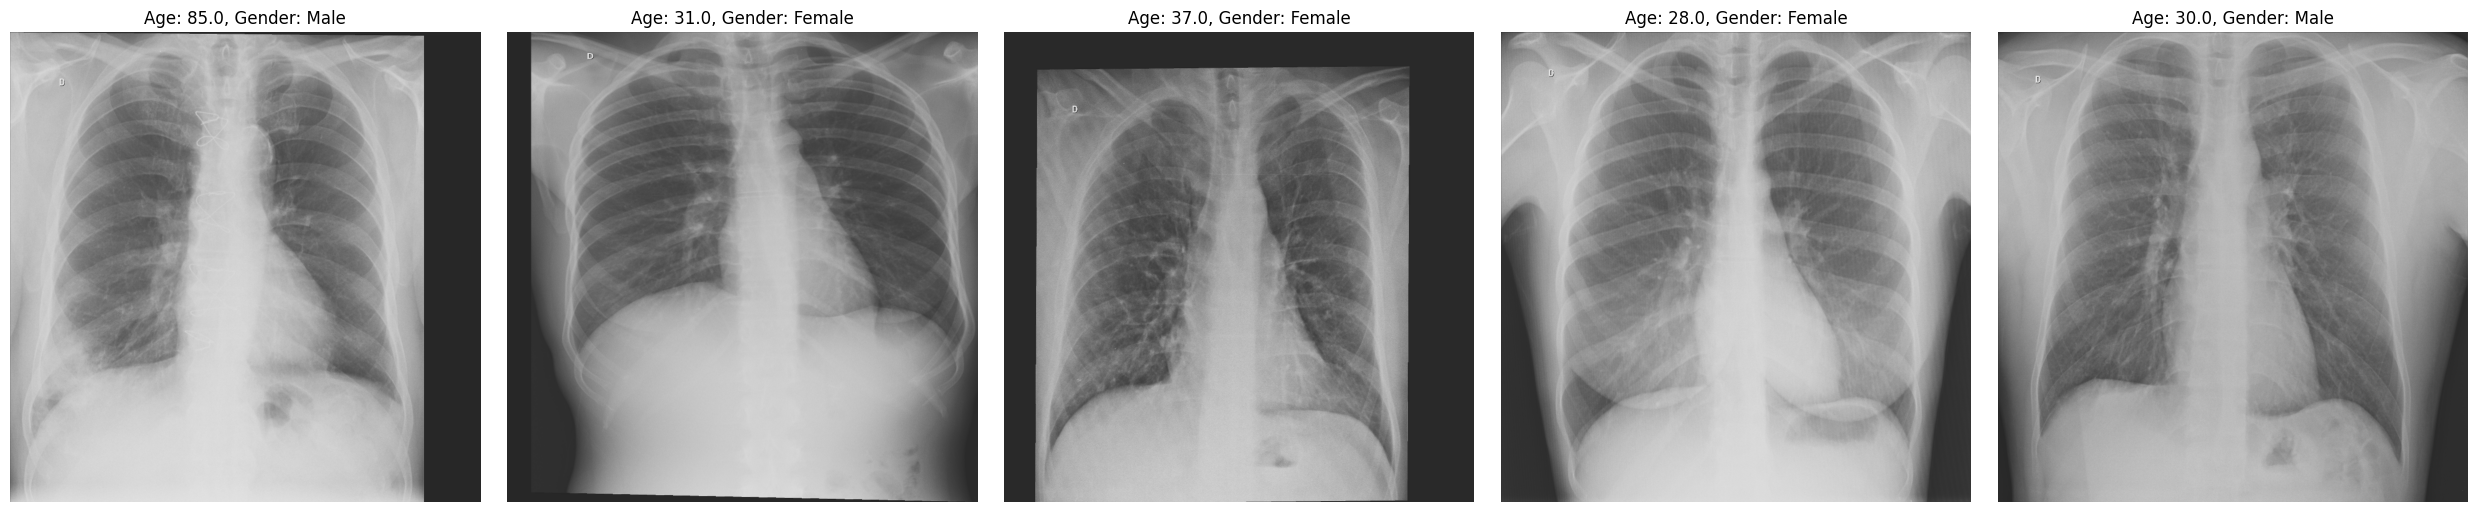

Test Sample Images:


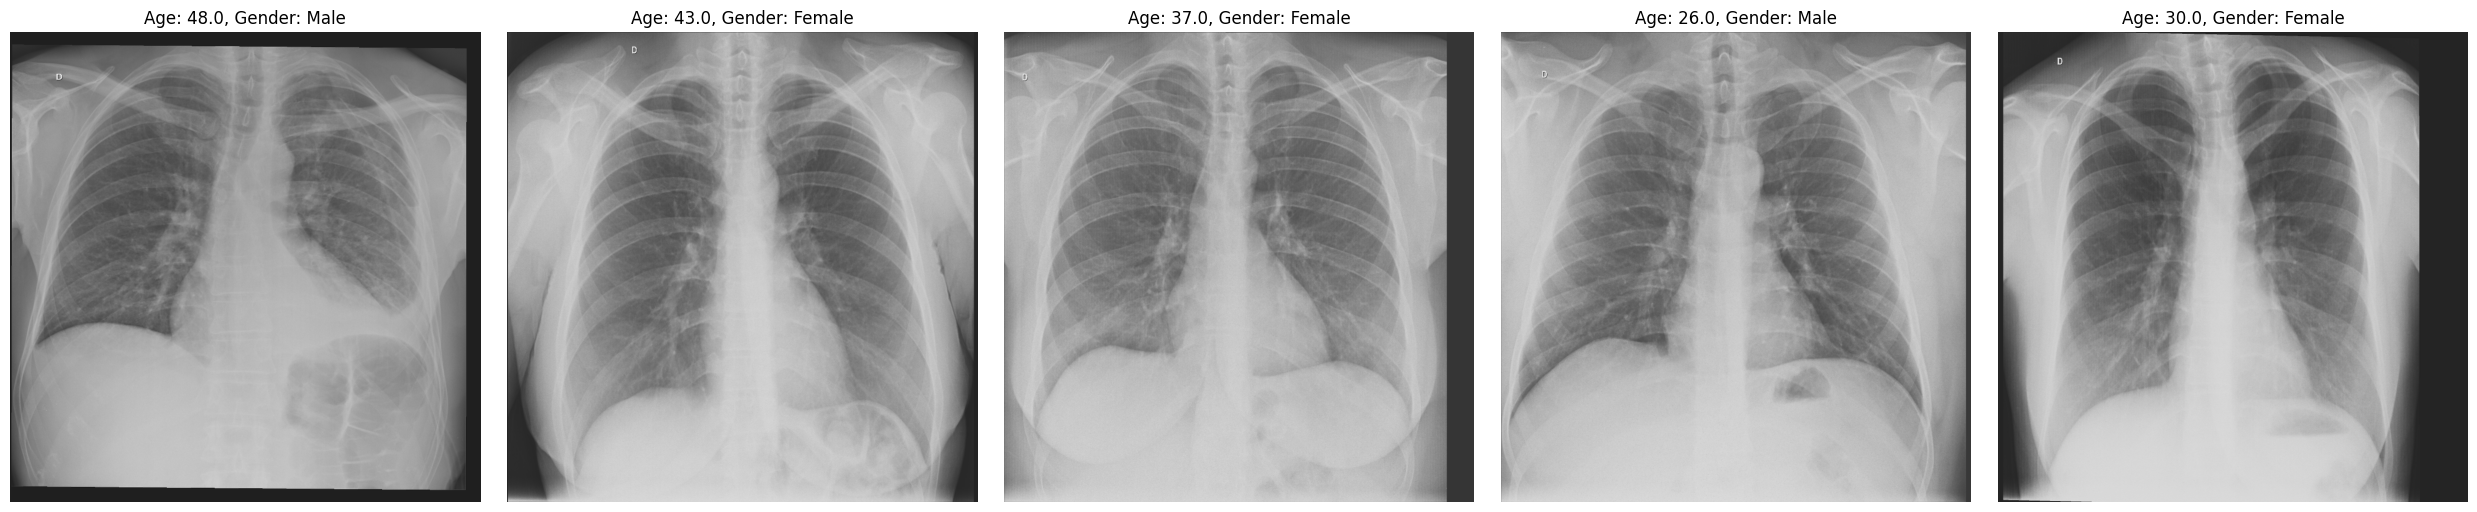

In [ ]:
splits = ['train', 'val', 'test']
num_samples = 5  

for split in splits:
    print(f"{split.capitalize()} Sample Images:")
    display_sample_images(root_dir, split, num_samples=num_samples)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, age_csv, gender_csv, transform=None):
        self.transform = transform
        age_df = pd.read_csv(age_csv, header=None, names=['image', 'age'])
        gender_df = pd.read_csv(gender_csv, header=None, names=['image', 'gender'])

        age_df['age'] = pd.to_numeric(age_df['age'], errors='coerce')

        age_df.dropna(subset=['age'], inplace=True)

        self.annotations = pd.merge(age_df, gender_df, on='image')
        self.annotations['age_group'] = pd.cut(self.annotations['age'],
                                               bins=[0, 29, 39, 49, 59, 69, 79, 89, 99],
                                               labels=['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'],
                                               right=True)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{str(self.annotations.iloc[idx, 0]).zfill(6)}.png")
        image = Image.open(img_name).convert('RGB')

        gender_binary = [1, 0] if int(self.annotations.iloc[idx, 2]) == 0 else [0, 1]
        age_groups = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
        age_group_binary = [1 if age_group == self.annotations.iloc[idx, 3] else 0 for age_group in age_groups]

        label = torch.tensor(gender_binary + age_group_binary, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = CustomDataset(root_dir + '/train', root_dir + '/train_age.csv', root_dir + '/train_gender.csv', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
val_dataset = CustomDataset(root_dir + '/val', root_dir + '/val_age.csv', root_dir + '/val_gender.csv', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
def imshow(img, labels, size=(20, 20)):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')

    rows, cols = 2, 4  
    img_height, img_width = img.shape[0], img.shape[1]
    for i, label in enumerate(labels):
        x = ((i % cols) + 0.5) * (img_width // cols)
        y = ((i // cols) + 0.5) * (img_height // rows)
        plt.text(x, y, label, color='white', fontsize=12, ha='center', va='center', backgroundcolor='black')

    plt.show()

In [ ]:
def decode_labels(labels):
    gender_map = {0: 'Female', 1: 'Male'}
    age_group_map = {0: '10s', 1: '20s', 2: '30s', 3: '40s', 4: '50s', 5: '60s', 6: '70s', 7: '80s'}

    decoded_labels = []
    for label in labels:
        gender = gender_map[label[0:2].argmax().item()]
        age_group = age_group_map[label[2:].argmax().item()]
        decoded_labels.append(f"{gender}, {age_group}")

    return decoded_labels

['Female, 70s', 'Female, 70s', 'Female, 50s', 'Female, 70s', 'Male, 70s', 'Female, 30s', 'Female, 10s', 'Male, 10s']


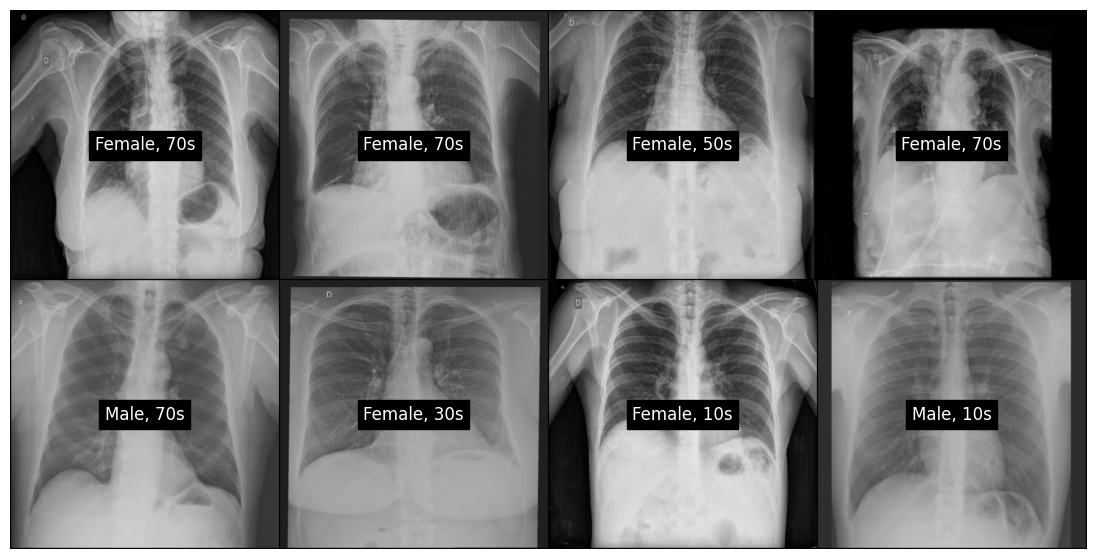

In [ ]:
dataiter = iter(train_loader)
images, binary_labels = next(dataiter)

prepared_labels = decode_labels(binary_labels)

print(prepared_labels[:8])

imshow(make_grid(images[:8], nrow=4), prepared_labels[:8], size=(15, 7))

### EfficientNet 모델 활용

In [ ]:
efficientnet = models.efficientnet_b5(pretrained=True)

for param in efficientnet.parameters():
    param.requires_grad = False

num_features = efficientnet.classifier[1].in_features  
efficientnet.classifier[1] = nn.Linear(num_features, 2)  #
for param in efficientnet.classifier[1].parameters():
    param.requires_grad = True

efficientnet = efficientnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    # optimizer 설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.0003, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.0003, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.0003, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()  
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels[:, :2] 
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        net.eval()  
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels[:, :2] 
                outputs = net(inputs)
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1) 
                total += labels.size(0)
                _, labels = torch.max(labels, 1)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [ ]:
train_losses_efficientnet, val_losses_efficientnet, val_accuracies_efficientnet = train_model('Adam', efficientnet, train_loader, val_loader, criterion, num_epochs=10)

Epoch 1/10: 100%|██████████| 88/88 [00:46<00:00,  1.88it/s]


[Adam] Epoch 1, Train Loss: 0.574756, Val Loss: 0.515369, Validation Accuracy: 73.57%


Epoch 2/10: 100%|██████████| 88/88 [00:46<00:00,  1.88it/s]


[Adam] Epoch 2, Train Loss: 0.466093, Val Loss: 0.427316, Validation Accuracy: 86.50%


Epoch 3/10: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]


[Adam] Epoch 3, Train Loss: 0.415823, Val Loss: 0.381447, Validation Accuracy: 86.14%


Epoch 4/10: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]


[Adam] Epoch 4, Train Loss: 0.395072, Val Loss: 0.352833, Validation Accuracy: 87.21%


Epoch 5/10: 100%|██████████| 88/88 [00:46<00:00,  1.88it/s]


[Adam] Epoch 5, Train Loss: 0.380265, Val Loss: 0.347421, Validation Accuracy: 87.00%


Epoch 6/10: 100%|██████████| 88/88 [00:46<00:00,  1.88it/s]


[Adam] Epoch 6, Train Loss: 0.366323, Val Loss: 0.337514, Validation Accuracy: 87.07%


Epoch 7/10: 100%|██████████| 88/88 [00:46<00:00,  1.88it/s]


[Adam] Epoch 7, Train Loss: 0.363009, Val Loss: 0.327910, Validation Accuracy: 87.64%


Epoch 8/10: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]


[Adam] Epoch 8, Train Loss: 0.352290, Val Loss: 0.315153, Validation Accuracy: 88.00%


Epoch 9/10: 100%|██████████| 88/88 [00:46<00:00,  1.88it/s]


[Adam] Epoch 9, Train Loss: 0.347032, Val Loss: 0.310630, Validation Accuracy: 88.21%


Epoch 10/10: 100%|██████████| 88/88 [00:46<00:00,  1.88it/s]

[Adam] Epoch 10, Train Loss: 0.343764, Val Loss: 0.300079, Validation Accuracy: 88.79%


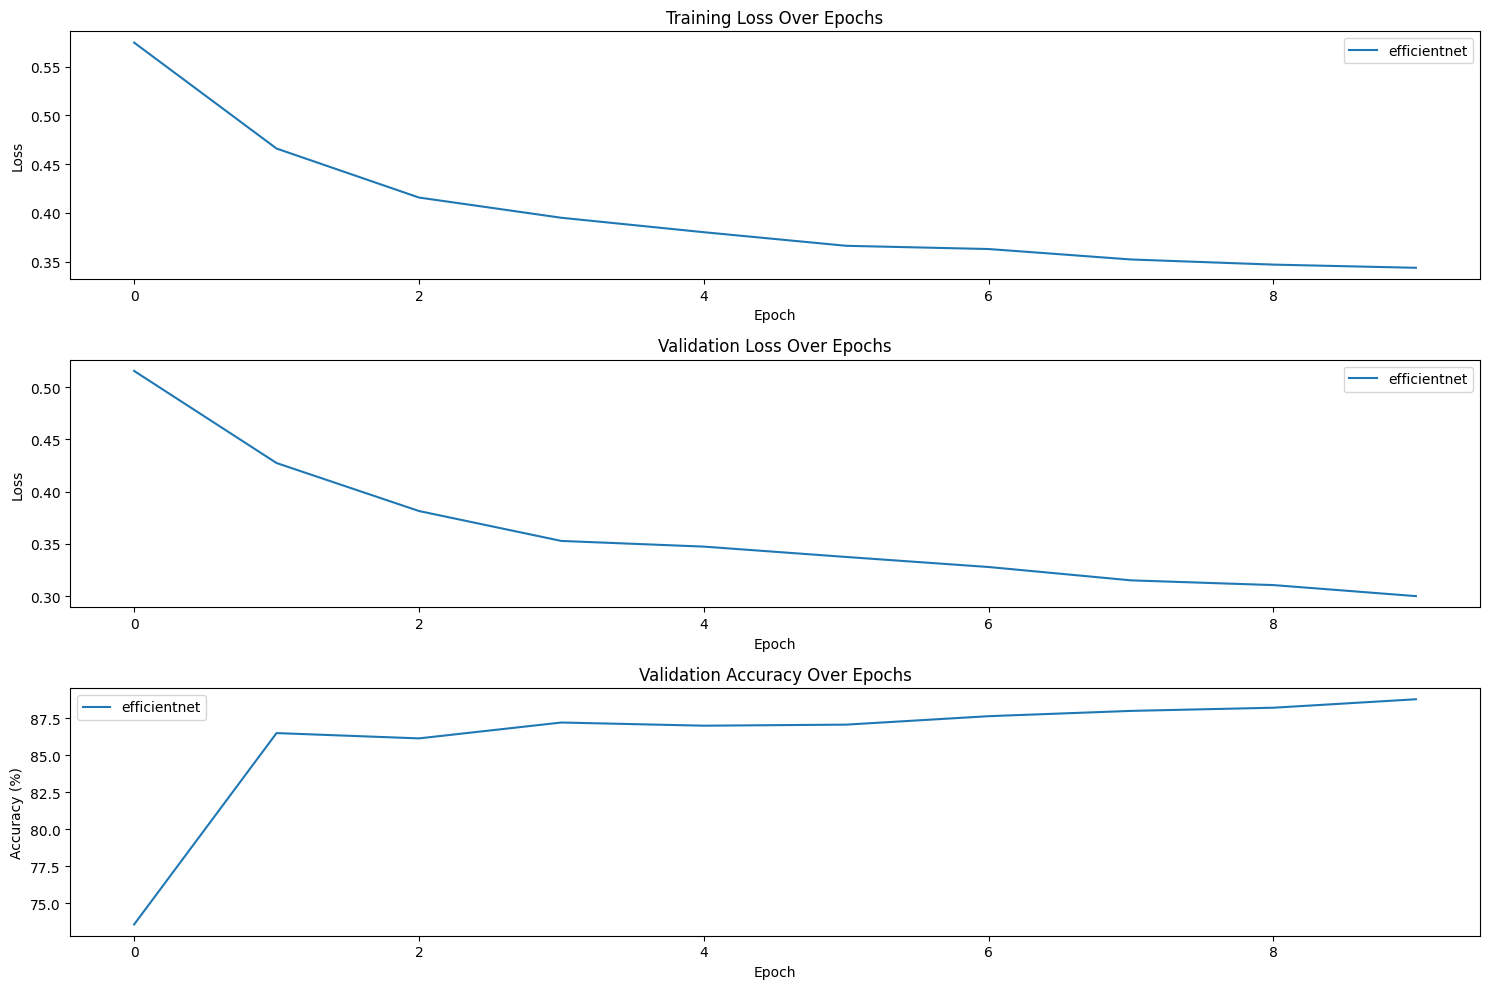

In [ ]:

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)  
plt.plot(train_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()


plt.subplot(3, 1, 3) 
plt.plot(val_accuracies_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()